In [1]:
import robot_plotter as rp
import models_functions as mf
import traj
import numpy as np
import matplotlib.pyplot as plt
import robot_sim as sim
import sim_helper_funcs as hfunc
import save_load_data as sldat

## Script for running many simulations of a particular trajectory
Run many simulations with set random seeds, for use with ANEES purposes. 

This one is for Luft et al's implementation of the CL algorithm

In [2]:
# generate reference trajectory
dt = 0.01

pos1, y_IMU1_base, xa1 = hfunc.path1_slow(dt)
pos2, y_IMU2_base, xa2 = hfunc.path2_slow(dt)
pos3, y_IMU3_base, xa3 = hfunc.path3_slow(dt)

pos_len = pos1.shape[1] # Assumes that all paths have the same length
#pos_len = round(120/dt) # overwrite for debugging

# Generate anchors position:
xanc1, xanc2 = hfunc.anc_setup1()
xanc3, xanc4 = hfunc.anc_setup2()

In [3]:
R_b = 0.0009
R_r = 0.001
R_w = 0.0002
R_a = 0.004

anchor1 = sim.Anchor(x0=xanc1, id=1)
anchor2 = sim.Anchor(x0=xanc2, id=2)


In [4]:
list_seeds = [1061]
#1061, 1, 19001, 7871871, 2289, 91667, 8, 6119077, 47, 5514
seeds_num = len(list_seeds)
# Initialize logs
x_logL1 = np.zeros((mf.STATE_LEN, pos_len, seeds_num))
P_logL1 = np.zeros((mf.STATE_LEN, mf.STATE_LEN, pos_len, seeds_num))
x_logL2 = np.zeros((mf.STATE_LEN, pos_len, seeds_num))
P_logL2 = np.zeros((mf.STATE_LEN, mf.STATE_LEN, pos_len, seeds_num))
x_logL3 = np.zeros((mf.STATE_LEN, pos_len, seeds_num))
P_logL3 = np.zeros((mf.STATE_LEN, mf.STATE_LEN, pos_len, seeds_num))
nis_log1 = np.zeros((pos_len, seeds_num))
nis_log2 = np.zeros((pos_len, seeds_num))
nis_log3 = np.zeros((pos_len, seeds_num))
nis_rb_log1 = np.zeros((pos_len, seeds_num))
nis_rb_log2 = np.zeros((pos_len, seeds_num))
nis_rb_log3 = np.zeros((pos_len, seeds_num))
rb_ids1 = np.zeros((pos_len, seeds_num))
rb_ids2 = np.zeros((pos_len, seeds_num))
rb_ids3 = np.zeros((pos_len, seeds_num))
biases1 = np.zeros((3, seeds_num))
biases2 = np.zeros((3, seeds_num))
biases3 = np.zeros((3, seeds_num))
abs_e_log1 = np.zeros((6, pos_len, seeds_num))
abs_e_log2 = np.zeros((6, pos_len, seeds_num))
abs_e_log3 = np.zeros((6, pos_len, seeds_num))

# Sim settings
sr = R_r
sb = R_b
r_w = R_w
r_a = R_a
sim_max_dist = 35
thres = 14.5 # 99.5 % confidence
thres_IMU = 14.5 # 99.5 % confidence
out_freq = np.array([[0.0],[0.0],[0.0]]) # an outlier every second on average
pout_r = 0
pout_b = 0
bias_base = np.array([[0.07],[0.2],[0.2]]) # max magnitude of bias
amb = True
update_freq = 1.0
meas_delay = 0.1
# Quick disabling of settings 
#thres = 0
thres_IMU = 0
#bias_base = np.array([[0.0],[0.0],[0.0]]) 
#sr=0
#sb=0
#r_w = 0
#r_a = 0

for j in range(seeds_num):
    print("seed: " + str(list_seeds[j]))
    np.random.seed(list_seeds[j])
    # random bias:
    bias_vec1 = 2*bias_base*(np.random.rand(3, 1) - 0.5)
    bias_vec2 = 2*bias_base*(np.random.rand(3, 1) - 0.5)
    bias_vec3 = 2*bias_base*(np.random.rand(3, 1) - 0.5)
    
    # Generate noise
    y_IMU1 = traj.gen_noise(y_IMU1_base.copy(), dt=dt, sigma=np.diag([r_w, r_a, r_a]), bias=bias_vec1, out_freq=out_freq)
    y_IMU2 = traj.gen_noise(y_IMU2_base.copy(), dt=dt, sigma=np.diag([r_w, r_a, r_a]), bias=bias_vec2, out_freq=out_freq)
    y_IMU3 = traj.gen_noise(y_IMU3_base.copy(), dt=dt, sigma=np.diag([r_w, r_a, r_a]), bias=bias_vec3, out_freq=out_freq)

    # Setup LUFT robots
    robotL1 = sim.robot_luft(x0=xa1, path=pos1, imu=y_IMU1, dt=dt, id=111, t=np.array([[1.0],[1.0]]))
    robotL2 = sim.robot_luft(x0=xa2, path=pos2, imu=y_IMU2, dt=dt, id=222, t=np.array([[1.0],[1.0]]))
    robotL3 = sim.robot_luft(x0=xa3, path=pos3, imu=y_IMU3, dt=dt, id=333, t=np.array([[1.0],[1.0]]))

    # Setup update params:
    robots_list = [robotL1, robotL2, robotL3]
    update_list = [anchor1, anchor2, robotL1, robotL2, robotL3]
    params = [sr, sb, thres, sim_max_dist, amb, True, pout_r, pout_b]

    # Run Lufts algorithm
    for i in range(pos_len-1):
        robotL1.predict(imu_correct=True, thres=thres_IMU)
        robotL2.predict(imu_correct=True, thres=thres_IMU)
        robotL3.predict(imu_correct=True, thres=thres_IMU)
        # Set up a measurement pattern similar to the used communication protocol
        hfunc.updateAllLuft(robots_list, [update_list]*3, [params]*3, i, dt, update_freq, meas_delay)
    
    # Save estimates and covariances:
    # Slicing, incase we want to run a shorter simulation
    x_logL1[:,:,j] = robotL1.x_log[:,:pos_len]
    P_logL1[:,:,:,j] = robotL1.P_log[:,:,:pos_len]
    x_logL2[:,:,j] = robotL2.x_log[:,:pos_len]
    P_logL2[:,:,:,j] = robotL2.P_log[:,:,:pos_len]
    x_logL3[:,:,j] = robotL3.x_log[:,:pos_len]
    P_logL3[:,:,:,j] = robotL3.P_log[:,:,:pos_len]
    nis_log1[:,j] = robotL1.nis_IMU[:pos_len]
    nis_log2[:,j] = robotL2.nis_IMU[:pos_len]
    nis_log3[:,j] = robotL3.nis_IMU[:pos_len]
    nis_rb_log1[:,j] = robotL1.nis_rb[:pos_len]
    nis_rb_log2[:,j] = robotL2.nis_rb[:pos_len]
    nis_rb_log3[:,j] = robotL3.nis_rb[:pos_len]
    rb_ids1[:,j] = robotL1.rb_ids[:pos_len]
    rb_ids2[:,j] = robotL2.rb_ids[:pos_len]
    rb_ids3[:,j] = robotL3.rb_ids[:pos_len]
    abs_e_log1[:,:,j] = sim.error_bp(robotL1, bias_vec1)[:,:pos_len]
    abs_e_log2[:,:,j] = sim.error_bp(robotL2, bias_vec2)[:,:pos_len]
    abs_e_log3[:,:,j] = sim.error_bp(robotL3, bias_vec3)[:,:pos_len]
    biases1[:,j] = bias_vec1[:,0]
    biases2[:,j] = bias_vec2[:,0]
    biases3[:,j] = bias_vec3[:,0]

# finally save to an pickle object:
robdat1 = sldat.RobotData(x_logL1, P_logL1, nis_log1, nis_rb_log1, pos1, biases1, rb_ids=rb_ids1, id=robotL1.id)
robdat2 = sldat.RobotData(x_logL2, P_logL2, nis_log2, nis_rb_log2, pos2, biases2, rb_ids=rb_ids2, id=robotL2.id)
robdat3 = sldat.RobotData(x_logL3, P_logL3, nis_log3, nis_rb_log3, pos3, biases3, rb_ids=rb_ids3, id=robotL3.id)
robcol = sldat.RobotCollection([robdat1, robdat2, robdat3], [xanc1, xanc2])
sldat.save_data(robcol, 'test')

seed: 1061
Robot 111 sees anchor 1 at time 0.01
Anchor 2 out of range for robot 111 at time 0.11
Robot 111 sees robot 222 at time 0.21
Adding new robot: 111
Adding new robot: 222
Robot 111 sees robot 333 at time 0.31
Adding new robot: 111
Adding new robot: 333
Robot 333 sees anchor 1 at time 0.35000000000000003
Anchor 2 out of range for robot 333 at time 0.45
Robot 333 sees robot 111 at time 0.55
Robot 333 sees robot 222 at time 0.65
Adding new robot: 333
Adding new robot: 222
Anchor 1 out of range for robot 222 at time 0.68
Anchor 2 out of range for robot 222 at time 0.78
Robot 222 sees robot 111 at time 0.88
Robot 222 sees robot 333 at time 0.98
Robot 111 sees anchor 1 at time 1.01
Anchor 2 out of range for robot 111 at time 1.11
Robot 111 sees robot 222 at time 1.21
Robot 111 sees robot 333 at time 1.31
Robot 333 sees anchor 1 at time 1.35
Anchor 2 out of range for robot 333 at time 1.45
Robot 333 sees robot 111 at time 1.55
Robot 333 sees robot 222 at time 1.6500000000000001
Anchor

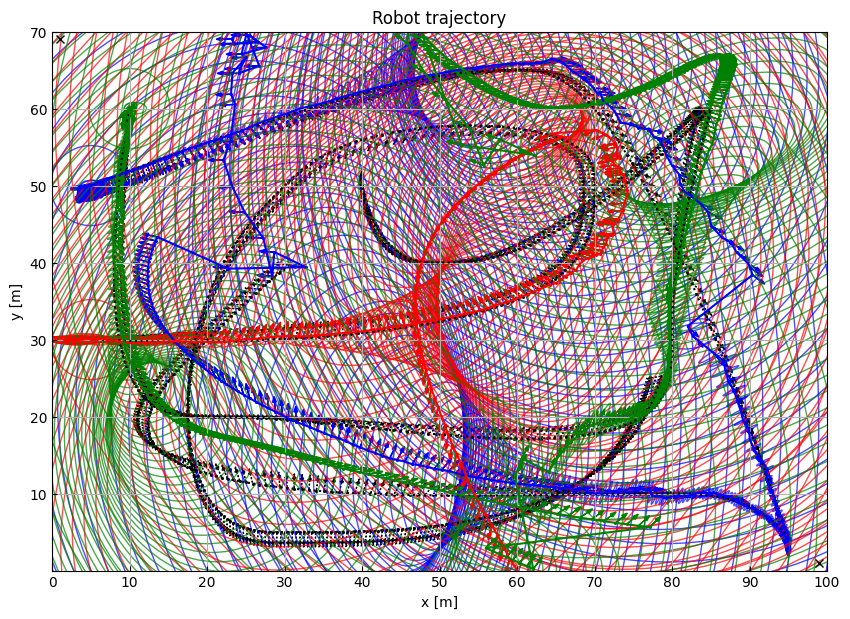

In [5]:
# Plot the choosen simulation:
s_idx = 0
start_t_idx = round(0/dt)
end_t_idx = round(400/dt)

# Plot ground truth
fig, ax = rp.setup_plot()
rp.plot_position(ax, pos1[:,start_t_idx:end_t_idx:100], color='black', marker=None, linestyle=':', label='Robot 1 reference')
rp.plot_position(ax, pos2[:,start_t_idx:end_t_idx:100], color='black', marker=None, linestyle=':', label='Robot 2 reference')
rp.plot_position(ax, pos3[:,start_t_idx:end_t_idx:100], color='black', marker=None, linestyle=':', label='Robot 3 reference')

# Plot states of robots:
rp.plot_position2(ax, x_logL1[:,start_t_idx:end_t_idx:100,s_idx], P_logL1[:,:,start_t_idx:end_t_idx:100,s_idx], color='blue', marker=None, label='Robot 1 trajectory')
rp.plot_position2(ax, x_logL2[:,start_t_idx:end_t_idx:100,s_idx], P_logL2[:,:,start_t_idx:end_t_idx:100,s_idx], color='red', marker=None, label='Robot 2 trajectory')
rp.plot_position2(ax, x_logL3[:,start_t_idx:end_t_idx:100,s_idx], P_logL3[:,:,start_t_idx:end_t_idx:100,s_idx], color='green', marker=None, label='Robot 3 trajectory')

anchor1.draw_position(ax, color='black')
anchor2.draw_position(ax, color='black')

#ax.legend()

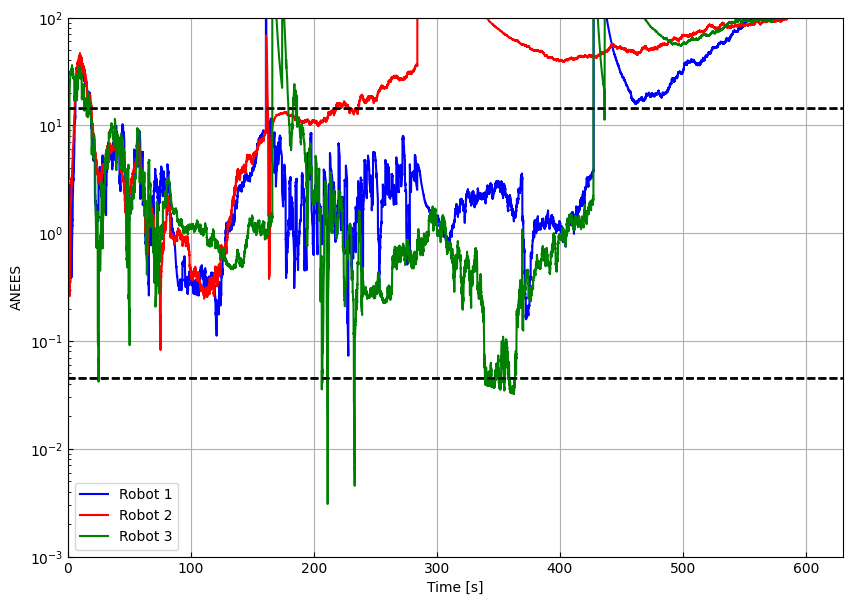

In [6]:
# Plot metrics:
# ANEES analysis
# If higher than confidence interval, then the estimate is overconfident
fig, ax_anees = plt.subplots(1, figsize=(10,7))
anees_sel = np.array([[True],[False],[False]])
pos_ind = [0, 2, 3]
#anees_sel = np.array([[False],[False]])
#pos_ind = [2, 3]
rp.plot_ANEES(ax_anees, 
             x_est=x_logL1[pos_ind,:],
             x_true=robotL1.path[:3,:], 
             P=P_logL1[np.ix_(pos_ind, pos_ind)], 
             rad_sel=anees_sel,
             dt=dt,
             prob=0.995,
             label='Robot 1')
rp.plot_ANEES(ax_anees, 
             x_est=x_logL2[pos_ind,:],
             x_true=robotL2.path[:3,:], 
             P=P_logL2[np.ix_(pos_ind, pos_ind)], 
             rad_sel=anees_sel,
             dt=dt,
             prob=0.995,
             color='red',
             label='Robot 2')
rp.plot_ANEES(ax_anees, 
             x_est=x_logL3[pos_ind,:],
             x_true=robotL3.path[:3,:], 
             P=P_logL3[np.ix_(pos_ind, pos_ind)], 
             rad_sel=anees_sel,
             dt=dt,
             prob=0.995,
             color='green',
             label='Robot 3')
ax_anees.set_ylim([0.001, 100])

ax_anees.legend()

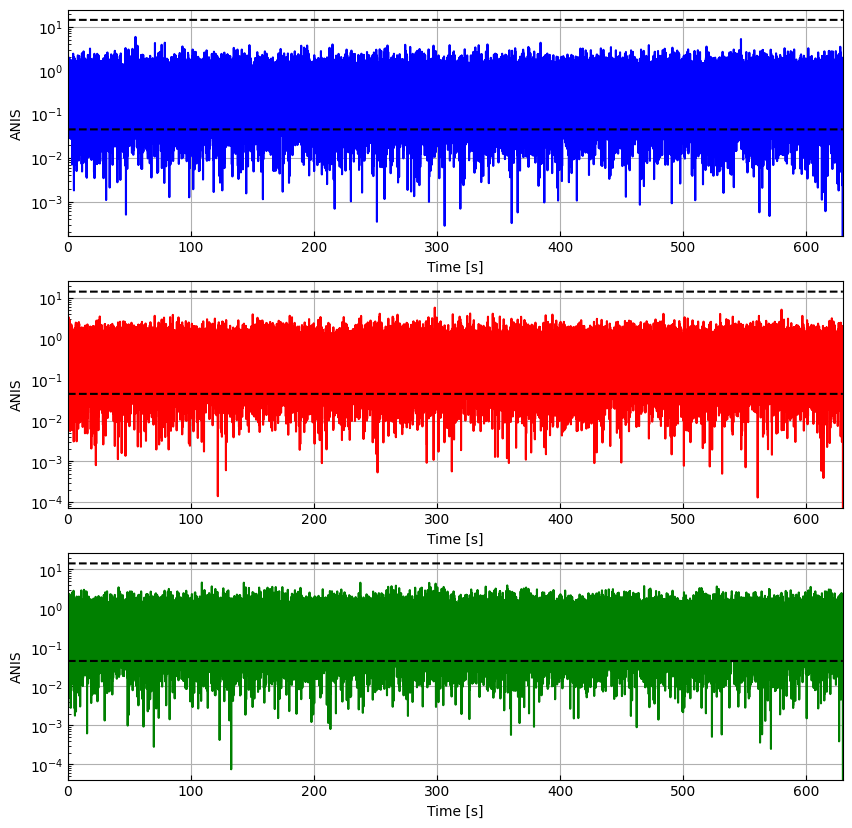

In [7]:
# ANIS analysis
fig, axnis = plt.subplots(3, figsize=(10,10))
# Three df
rp.plot_ANIS(ax=axnis[0], nis=nis_log1, df=3, dt=dt, prob=0.995, color='blue')
rp.plot_ANIS(ax=axnis[1], nis=nis_log2, df=3, dt=dt, prob=0.995, color='red')
rp.plot_ANIS(ax=axnis[2], nis=nis_log3, df=3, dt=dt, prob=0.995, color='green')

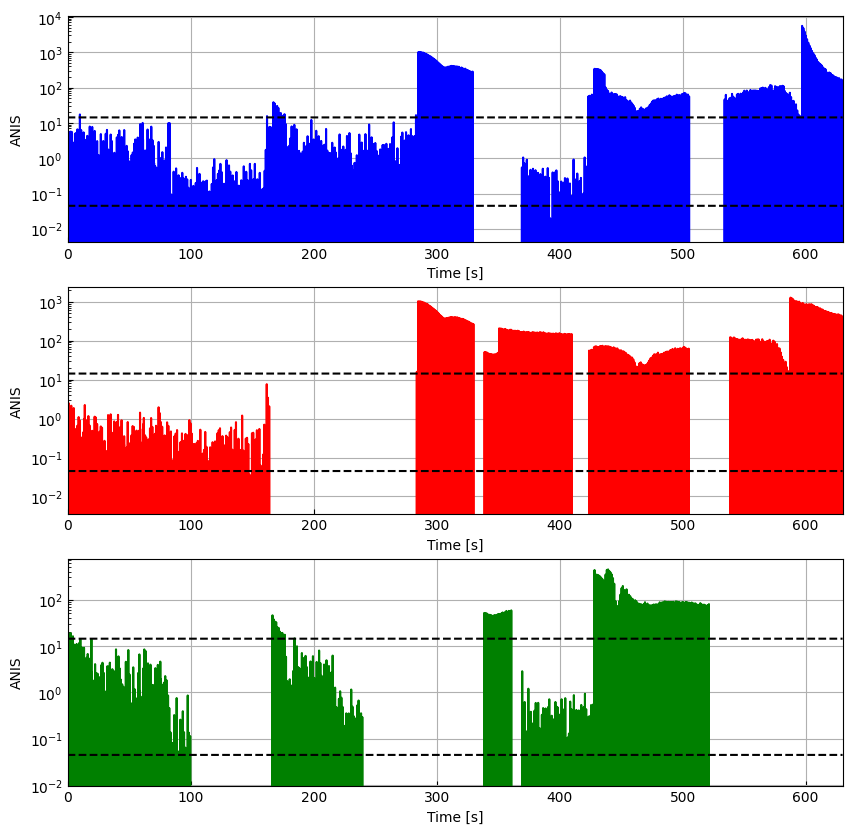

In [8]:
# ANIS analysis
fig, axnis = plt.subplots(3, figsize=(10,10))
# Three df
rp.plot_ANIS(ax=axnis[0], nis=nis_rb_log1, df=3, dt=dt, prob=0.995, color='blue')
rp.plot_ANIS(ax=axnis[1], nis=nis_rb_log2, df=3, dt=dt, prob=0.995, color='red')
rp.plot_ANIS(ax=axnis[2], nis=nis_rb_log3, df=3, dt=dt, prob=0.995, color='green')

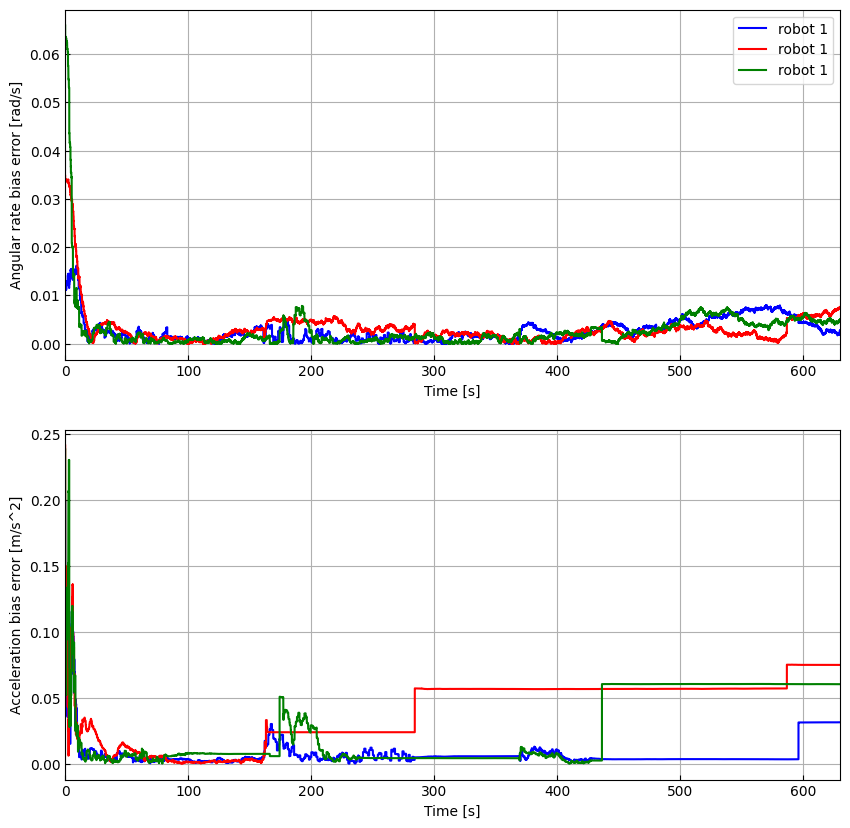

In [9]:
# Plot the absolute bias error:
fig, axbp = plt.subplots(2, figsize=(10,10))

rp.plot_abs_avg(axbp, abs_e_log1, dt=dt, pos=False, colors=['blue', 'blue'], labels=['robot 1', 'robot 1'])
rp.plot_abs_avg(axbp, abs_e_log2, dt=dt, pos=False, colors=['red','red'], labels=['robot 1', 'robot 1'])
rp.plot_abs_avg(axbp, abs_e_log3, dt=dt, pos=False, colors=['green', 'green'], labels=['robot 1', 'robot 1'])
axbp[0].legend()


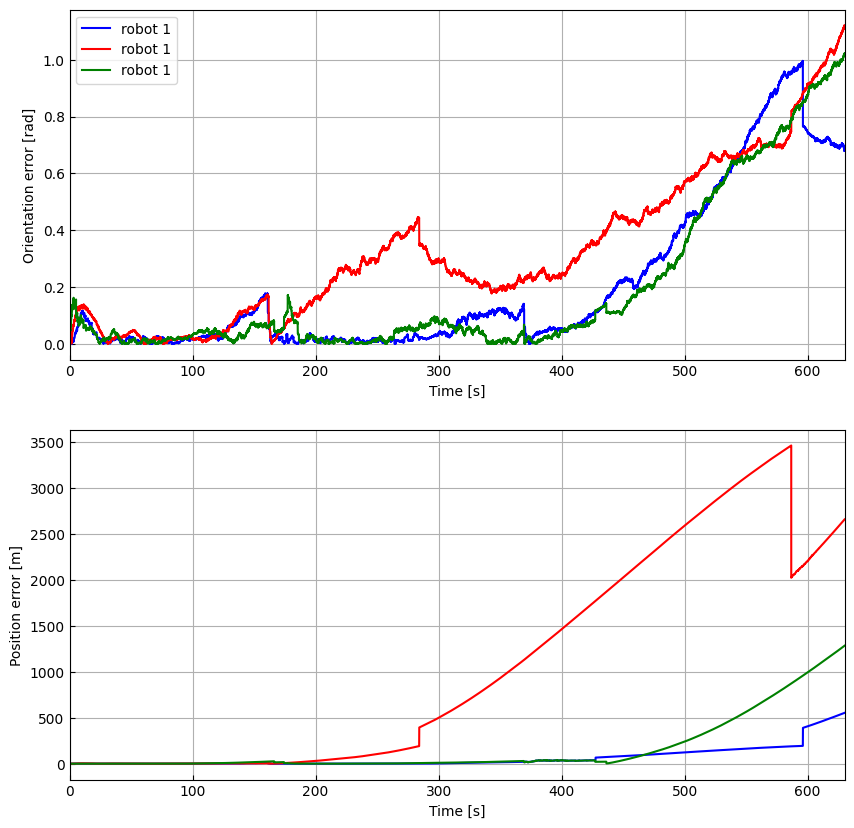

In [10]:
# Plot the absolute positioning error:
fig, axpos = plt.subplots(2, figsize=(10,10))

rp.plot_abs_avg(axpos, abs_e_log1, dt=dt, pos=True, colors=['blue', 'blue'], labels=['robot 1', 'robot 1'])
rp.plot_abs_avg(axpos, abs_e_log2, dt=dt, pos=True, colors=['red','red'], labels=['robot 1', 'robot 1'])
rp.plot_abs_avg(axpos, abs_e_log3, dt=dt, pos=True, colors=['green', 'green'], labels=['robot 1', 'robot 1'])
axpos[0].legend()

Interesting things to check:
- Anchor placements: If they are very close together, does the estimate then suffer?
- Daisy chain length: If there is a very long chain of drones with only these at the very end having connection to anchors, how does that affect the localization?
- Can a large group still keep consistency?
- What if communication is cut out at various points?
- How long can a group stay consistent, after communication is cut out? and can they recover?
- Outliers! (Important - how does the system handle these?)
    Only with anchors/IMU out: Filter has trouble maintaing consistency, but does not diverge 
- Fast drones with fast turning.
- Lot of orientation shifts (will ML fail?)

TODO:
- Try increasing covariance of measurments, ONLY for relative measurements, to prioritize anchor measurements better
- Dynamic thresholding: Based on the covariance of the bias estimates, decrease the thresholds
- Maximum threshold - just do handtuning

More notes:
- It seems that daisy chains are more susepticle to being thrown off by ML errors - its very dependent on both measurements being correct. If one happens, the system is then having a hard time to recover from it
